# Wrangle and Analyze Data Project

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy as tweepy
import json
from tweepy.parsers import JSONParser
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re

## Gather Data

In [2]:
# Read in the twitter archive enhanced csv given to us
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Gather image predictions from Udacity's servers
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# check response code
response

<Response [200]>

In [4]:
# Save the provided image predictions
with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [5]:
# Read the image predictions tsv file into a dataframe
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
# Access the twitter archives using your unique keys and tokens
consumer_key = '##########'
consumer_secret = '##########'
access_token = '##########'
access_secret = '##########'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=JSONParser(), wait_on_rate_limit=True)

In [11]:
# Do a test run of the api
tweet = api.get_status(887473957103951883,tweet_mode='extended')

In [12]:
# Testing
print(tweet['id'])
print(tweet['retweet_count'])

887473957103951883
17792


In [14]:
# Query the api and get erroneous tweets. Track timing of tweet completion as well.
df_list = []
errors_list = []

tweets = df_twitter_archive['tweet_id']

now = time.time()

for index, t in enumerate(tweets):

    try:
        start = time.time()
        tweet = api.get_status(t,tweet_mode='extended')
        end = time.time()
        print("Reading Tweet {}/{}. ({}%) complete. Elapsed Time = {}".format((index+1),len(tweets), round(((index+1)/len(tweets)) * 100,1), round((end - start),2)))
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        df_list.append({'tweet_id':int(t),
                        'retweet_count':int(retweet_count),
                        'favorite_count':int(favorite_count)
                       })

    
    
    except Exception as e:
        print(str(t) + str(e))
        errors_list.append(t)

then = time.time()
diff = round(then - now)
minutes = diff // 60
seconds = diff % 60
print("Reading Process Completed. Elapsed Time is {}:{}".format(minutes, seconds))

Reading Tweet 1/2356. (0.0%) complete. Elapsed Time = 0.19
Reading Tweet 2/2356. (0.1%) complete. Elapsed Time = 0.17
Reading Tweet 3/2356. (0.1%) complete. Elapsed Time = 0.17
Reading Tweet 4/2356. (0.2%) complete. Elapsed Time = 0.23
Reading Tweet 5/2356. (0.2%) complete. Elapsed Time = 0.21
Reading Tweet 6/2356. (0.3%) complete. Elapsed Time = 0.23
Reading Tweet 7/2356. (0.3%) complete. Elapsed Time = 0.21
Reading Tweet 8/2356. (0.3%) complete. Elapsed Time = 0.17
Reading Tweet 9/2356. (0.4%) complete. Elapsed Time = 0.38
Reading Tweet 10/2356. (0.4%) complete. Elapsed Time = 0.2
Reading Tweet 11/2356. (0.5%) complete. Elapsed Time = 0.19
Reading Tweet 12/2356. (0.5%) complete. Elapsed Time = 0.22
Reading Tweet 13/2356. (0.6%) complete. Elapsed Time = 0.19
Reading Tweet 14/2356. (0.6%) complete. Elapsed Time = 0.18
Reading Tweet 15/2356. (0.6%) complete. Elapsed Time = 0.2
Reading Tweet 16/2356. (0.7%) complete. Elapsed Time = 0.19
Reading Tweet 17/2356. (0.7%) complete. Elapsed Tim

In [15]:
errors_list

[888202515573088257,
 873697596434513921,
 872668790621863937,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 845459076796616705,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 775096608509886464,
 770743923962707968,
 754011816964026368,
 680055455951884288]

In [23]:
# save df of queried tweets to JSON and then convert to a dataframe
df_json = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
df_json.to_json('tweet_json.txt')
df_json = pd.read_json('tweet_json.txt')
df_json.head()

,favorite_count,retweet_count,tweet_id
0,38044,8321,892420643555336193
1,32670,6148,892177421306343426
10,30108,7178,890006608113172480
100,40160,8939,872486979161796608
1000,10070,4280,747103485104099331


## Assess Data

### **df_twitter_archive assessments**<br />

In [13]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
803,772152991789019136,NaN,NaN,2016-09-03 19:23:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a couple rufferees making sure all the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772152991...,10,10,None,None,None,None,None
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1154,725458796924002305,NaN,NaN,2016-04-27 22:57:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pup had to be removed cuz it wouldn't have bee...,NaN,NaN,NaN,https://twitter.com/foxdeportes/status/7251360...,13,10,None,None,None,None,None
2229,668248472370458624,NaN,NaN,2015-11-22 02:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He is a Brown Douglass ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668248472...,8,10,Bisquick,None,None,None,None
308,835574547218894849,NaN,NaN,2017-02-25 19:37:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eli. He works backstage at Bone Jovi c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835574547...,11,10,Eli,None,None,None,None
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @katieornah: @dog_rates learning a lot at c...,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,https://twitter.com/katieornah/status/77100213...,12,10,None,None,None,pupper,None
2080,670823764196741120,NaN,NaN,2015-11-29 04:37:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Remington. He's a man dime. 12/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670823764...,12,10,Remington,None,None,None,None
317,834786237630337024,NaN,NaN,2017-02-23 15:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tobi. She is properly fetching her sho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834786237...,13,10,Tobi,None,None,None,None
1458,695074328191332352,NaN,NaN,2016-02-04 02:40:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lorenzo. He's educated af. Just gradua...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695074328...,11,10,Lorenzo,None,None,pupper,None
1572,687664829264453632,NaN,NaN,2016-01-14 15:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Opal. He's a Belgian Dijon Poofster. Upse...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687664829...,11,10,Opal,None,None,None,None


In [15]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
df_twitter_archive['expanded_urls'].isnull().sum()

59

In [17]:
df_twitter_archive['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
an             7
Bailey         7
Daisy          7
Buddy          7
Toby           7
Scout          6
Oscar          6
Leo            6
Koda           6
Jack           6
Rusty          6
Dave           6
Jax            6
Milo           6
Stanley        6
Bella          6
George         5
            ... 
Shadoe         1
Ronnie         1
Marty          1
Hubertson      1
Meatball       1
Rumble         1
Samsom         1
light          1
Grizzwald      1
Sprout         1
Pupcasso       1
Pherb          1
Striker        1
Fabio          1
Tessa          1
Jangle         1
Maxwell        1
Noah           1
Geno           1
Mya            1
Rilo           1
Pip            1
Herb           1
Bauer          1
Ebby           1
Godzilla       1
Lugan          1
Barney        

In [18]:
df_twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
df_twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [20]:
df_twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

**observations**

quality issues:
- Name column has "None", "a", "the", and "an" names that are not real names
- timestamp date is incorrect format(unecessary +0000 in date). The timestamp data type is wrong; object should be changed to time
- data type of tweet_id should be string instead of object
- there are 59 null entries in the expanded_urls column
- rating_denominator column should only have one denominator value - 10 
- rating_numerator have values lower than 10 that should be removed.
- some ratings can be extracted from the text of the tweet and be used to fill in the rating_numerator column<br />

tidiness issues:<br />
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns have null values in them. This is an issue because we want only the original tweets. We will drop these columns later in the project.

### **image_predictions assessments**

In [21]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
192,669567591774625800,https://pbs.twimg.com/media/CUrIK1DWoAAhECq.jpg,1,Chihuahua,0.980511,True,toy_terrier,0.009166,True,miniature_pinscher,0.002659,True
1507,785639753186217984,https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg,1,porcupine,0.978042,False,sea_urchin,0.006106,False,echidna,0.005442,False
448,674690135443775488,https://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg,1,tick,0.242538,False,nail,0.212589,False,screw,0.172838,False
417,674024893172875264,https://pbs.twimg.com/media/CVqeEKLW4AA1wXH.jpg,1,Pomeranian,0.648500,True,Pekinese,0.339835,True,Persian_cat,0.006448,False
978,707059547140169728,https://pbs.twimg.com/media/Cc_64zVWEAAeXs7.jpg,1,Samoyed,0.897312,True,Great_Pyrenees,0.039180,True,kuvasz,0.019516,True
645,681610798867845120,https://pbs.twimg.com/media/CXWRZBgWkAEHMea.jpg,1,toy_poodle,0.821704,True,miniature_poodle,0.116042,True,Yorkshire_terrier,0.014847,True
1792,830956169170665475,https://pbs.twimg.com/ext_tw_video_thumb/83095...,1,kuvasz,0.451516,True,golden_retriever,0.317196,True,English_setter,0.132759,True
313,671561002136281088,https://pbs.twimg.com/media/CVHdK-7WwAAsuyc.jpg,1,Gordon_setter,0.469373,True,black-and-tan_coonhound,0.270893,True,Rottweiler,0.153233,True
584,678969228704284672,https://pbs.twimg.com/media/CWwu6OLUkAEo3gq.jpg,1,Labrador_retriever,0.680251,True,Chesapeake_Bay_retriever,0.201697,True,golden_retriever,0.019676,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**observations** <br />

quality issues:<br />
- some names of dogs are capitalized and some are not in the p1, p2, and p3 columns

tidiness issues: <br />
- df_twitter_archive, image predictions, and df_json can be combined into one table since they all describe one tweet

### **df_json assessments**

In [24]:
df_json.head()

,favorite_count,retweet_count,tweet_id
0,38044,8321,892420643555336193
1,32670,6148,892177421306343426
10,30108,7178,890006608113172480
100,40160,8939,872486979161796608
1000,10070,4280,747103485104099331


In [24]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
Unnamed: 0        2340 non-null int64
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(4)
memory usage: 73.2 KB


**observations**<br />

tidiness issues: <br />
- "Unamed: 0" column should be dropped since it is only an index column

## Clean Data

In [40]:
# Make a copy of the dataframes before starting the cleaning process
df_twitter_archive_clean = df_twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
df_json_clean = df_json.copy()

### Clean 8 Quality Issues

**Issue #1:**<br />

**Define** <br />
Dog names "None", "a", "the" and "an" should be replaced

**Code**

In [41]:
# Replace the dog names that are not names to NaN. There are many more dog names that are not really dog names 
# but for this example, we will only clean the ones found in the value_counts listing from the assessments above
df_twitter_archive_clean['name'].replace("None", "NaN", inplace= True)
df_twitter_archive_clean['name'].replace("a", "NaN", inplace= True)
df_twitter_archive_clean['name'].replace("the", "NaN", inplace= True)
df_twitter_archive_clean['name'].replace("an", "NaN", inplace= True)

**Test**

In [42]:
'None' in df_twitter_archive_clean['name']
'a' in df_twitter_archive_clean['name']
'the' in df_twitter_archive_clean['name']
'an' in df_twitter_archive_clean['name']

False

**Issue #2:** <br />

**Define**<br />
Timestamp format is incorrect. Change timestamp data type from object to datetime. The +0000 will drop

**Code**

In [43]:
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'])

**Test**

In [44]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Issue #3:**<br />

**Define** <br />
Data type of tweet_id should be string, not object. We need to change the tweet_id of image_predictions_clean dataframe and df_json_clean dataframe to string as well.

**Code**

In [45]:
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)
df_json_clean.tweet_id = df_json_clean.tweet_id.astype(str)

**Test**

In [46]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

**Issue #4:** <br />

**Define**<br />
The expanded_urls column has null values that need to be dropped. There are 59 total that we observed from the assessments.

**Code**

In [47]:
# Drop the null values in the expanded_urls column
df_twitter_archive_clean["expanded_urls"].dropna(inplace= True)

**Test**

In [48]:
"NaN" in df_twitter_archive_clean["expanded_urls"]

False

**Issue #5:** <br />

**Define**<br />
The rating_denominator column should only have the denominator 10

**Code**

In [105]:
df_twitter_archive_clean["rating_denominator"] = 10

**Test**

In [50]:
df_twitter_archive_clean.rating_denominator.value_counts()

10    2356
Name: rating_denominator, dtype: int64

**Issue #6:** <br />

**Define**<br />
The numerator column should exclude numbers less than 10 but just for an example, we will only exclude the values 0, 1, and 2. There should be 20 entries excluded based on the assessments we have done but because we have already started cleaning and dropping columns and rows, there are only 15 entries to be excluded now.

**Code**

In [51]:
# Recreate the dataframe by excluding the rating_numerator that are equal to 0, 1, and 2
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 0]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 1]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 2]

**Test**

In [52]:
df_twitter_archive_clean['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
420       2
15        2
75        2
17        1
121       1
99        1
45        1
27        1
20        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
144       1
182       1
204       1
143       1
666       1
960       1
1776      1
165       1
Name: rating_numerator, dtype: int64

**Issue #7:** <br />

**Define**<br />
We can extract numerator ratings from the tweet text and fill the missing values in rating_numerator column by finding the pattern ##.##

**Code**

In [53]:
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean.text.str.extract('(\d?\d*\.?\d\d*/)', expand=False)


**Test**

In [54]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']=='680494726643068929']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,11.26/,10,NaN,None,None,None,None


**Define**<br />

Replace the / character from the rating_numerator column

**Code**

In [55]:
df_twitter_archive_clean['rating_numerator'].replace('/','', regex=True, inplace=True)

**Test**

In [56]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']=='680494726643068929']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,11.26,10,NaN,None,None,None,None


**Issue #8:** <br />

**Define**<br />
There are capitalized and lower cased names in the p1, p2, and p3 columns. Replace all dog names in these columns with a lower case letter.

**Code**

In [57]:
image_predictions_clean['p1'] = image_predictions_clean['p1'].str.lower()
image_predictions_clean['p2'] = image_predictions_clean['p2'].str.lower()
image_predictions_clean['p3'] = image_predictions_clean['p3'].str.lower()

**Test**

In [58]:
image_predictions_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
218,670073503555706880,https://pbs.twimg.com/media/CUyUSuWXIAAZKYF.jpg,1,malamute,0.601886,True,siberian_husky,0.340106,True,eskimo_dog,0.050041,True
183,669353438988365824,https://pbs.twimg.com/media/CUoFZTyW4AE70iD.jpg,1,teddy,0.379656,False,pembroke,0.212343,True,chow,0.096995,True
1611,801285448605831168,https://pbs.twimg.com/media/Cx683NPUAAAjyU4.jpg,1,minivan,0.789376,False,beach_wagon,0.081125,False,convertible,0.064534,False
182,669351434509529089,https://pbs.twimg.com/media/CUoDk8mWsAAMyBL.jpg,1,cuirass,0.756829,False,breastplate,0.233520,False,bulletproof_vest,0.003812,False
1728,820690176645140481,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,2,west_highland_white_terrier,0.872064,True,kuvasz,0.059526,True,samoyed,0.037400,True
503,675878199931371520,https://pbs.twimg.com/media/CWEzo19WoAEiOCj.jpg,1,wood_rabbit,0.785756,False,hare,0.118181,False,cardigan,0.043627,True
993,708119489313951744,https://pbs.twimg.com/media/CdO-6x5W8AENSBJ.jpg,1,norwich_terrier,0.264483,True,norfolk_terrier,0.258786,True,chow,0.096899,True
1085,718613305783398402,https://pbs.twimg.com/media/CfkG_PMWsAAH0MZ.jpg,1,labrador_retriever,0.584580,True,german_short-haired_pointer,0.340657,True,chesapeake_bay_retriever,0.031975,True
1466,778650543019483137,https://pbs.twimg.com/media/Cs5ShihWEAAH2ti.jpg,1,german_shepherd,0.515699,True,malinois,0.300292,True,kelpie,0.087022,True
156,668826086256599040,https://pbs.twimg.com/media/CUglxbFXAAA5O0d.jpg,1,malinois,0.640185,True,irish_terrier,0.153700,True,rhodesian_ridgeback,0.068457,True


### Clean 2 Tidiness Issues

**Issue #1:**<br />

**Define** <br />
Remove the retweeted images because we only want original tweets. We will drop the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp. From the df_json_clean dataset we can drop the "Unnamed: 0" column.

**Code**

In [59]:
# Drop the "in-reply", "retweeted", and "Unnamed: 0" columns 
df_twitter_archive_clean.drop(['in_reply_to_status_id'], axis=1, inplace = True)
df_twitter_archive_clean.drop(['in_reply_to_user_id'], axis=1, inplace = True)
df_twitter_archive_clean.drop(['retweeted_status_id'], axis=1, inplace = True)
df_twitter_archive_clean.drop(['retweeted_status_user_id'], axis=1, inplace = True)
df_twitter_archive_clean.drop(['retweeted_status_timestamp'], axis=1, inplace = True)
df_json_clean.drop(['Unnamed: 0'], axis = 1, inplace= True)

**Test**

In [60]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2336 non-null object
timestamp             2336 non-null datetime64[ns]
source                2336 non-null object
text                  2336 non-null object
expanded_urls         2280 non-null object
rating_numerator      2336 non-null object
rating_denominator    2336 non-null int64
name                  2336 non-null object
doggo                 2336 non-null object
floofer               2336 non-null object
pupper                2336 non-null object
puppo                 2336 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 237.2+ KB


In [61]:
df_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null object
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


**Issue #2:**<br />

**Define** <br />
We can combine all three datasets into one dataset called twitter_master_df. First we will combine the df_twitter_archive_clean dataset with image_predictions_clean dataset. Then we will combine that dataset with the df_json_clean dataset to make one master dataset.

**Code**

In [62]:
archive_predictions = pd.merge(df_twitter_archive_clean, image_predictions_clean, how='left', on='tweet_id')

**Test**

In [63]:
archive_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 23 columns):
tweet_id              2336 non-null object
timestamp             2336 non-null datetime64[ns]
source                2336 non-null object
text                  2336 non-null object
expanded_urls         2280 non-null object
rating_numerator      2336 non-null object
rating_denominator    2336 non-null int64
name                  2336 non-null object
doggo                 2336 non-null object
floofer               2336 non-null object
pupper                2336 non-null object
puppo                 2336 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null object
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null object
p3                    2

**Define**<br />
Combine the archive_predictions dataset with the df_json_clean dataset to make a master dataset.

**Code**

In [64]:
df_twitter_master = pd.merge(archive_predictions, df_json_clean, how='left', on='tweet_id')

**Test**

In [65]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 25 columns):
tweet_id              2336 non-null object
timestamp             2336 non-null datetime64[ns]
source                2336 non-null object
text                  2336 non-null object
expanded_urls         2280 non-null object
rating_numerator      2336 non-null object
rating_denominator    2336 non-null int64
name                  2336 non-null object
doggo                 2336 non-null object
floofer               2336 non-null object
pupper                2336 non-null object
puppo                 2336 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null object
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null object
p3                    2

**Define**<br />
Drop any rows that do not contain a jpg_url. This will enable easier analyses later on.

**Code**

In [66]:
df_twitter_master = df_twitter_master[df_twitter_master['jpg_url'].notnull()]

**Test**

In [67]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2335
Data columns (total 25 columns):
tweet_id              2059 non-null object
timestamp             2059 non-null datetime64[ns]
source                2059 non-null object
text                  2059 non-null object
expanded_urls         2059 non-null object
rating_numerator      2059 non-null object
rating_denominator    2059 non-null int64
name                  2059 non-null object
doggo                 2059 non-null object
floofer               2059 non-null object
pupper                2059 non-null object
puppo                 2059 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null object
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null object
p3                    2

**Define**<br />
Set the following columns to the correct data type:<br />
p1_dog, p2_dog, p3_dog --> bool<br />
rating_numerator --> float<br />

**Code**

In [68]:
df_twitter_master['p1_dog'] = df_twitter_master['p1_dog'].astype(bool)
df_twitter_master['p2_dog'] = df_twitter_master['p2_dog'].astype(bool)
df_twitter_master['p3_dog'] = df_twitter_master['p3_dog'].astype(bool)
df_twitter_master['rating_numerator'] = df_twitter_master['rating_numerator'].astype(float)

**Test**

In [69]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2335
Data columns (total 25 columns):
tweet_id              2059 non-null object
timestamp             2059 non-null datetime64[ns]
source                2059 non-null object
text                  2059 non-null object
expanded_urls         2059 non-null object
rating_numerator      2059 non-null float64
rating_denominator    2059 non-null int64
name                  2059 non-null object
doggo                 2059 non-null object
floofer               2059 non-null object
pupper                2059 non-null object
puppo                 2059 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null bool
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null bool
p3                    2059

**Issue #3(for fun):**<br />

**Define** <br />
The columns doggo, floofer, pupper, and puppo can be condensed into one column called Stage with the possible variables as doggo, floofer, pupper, and puppo. 

**Code**

In [70]:
# First, we will substitute all the NaN for null values. 
df_twitter_master['doggo'].replace(np.nan,'', inplace=True)
df_twitter_master['floofer'].replace(np.nan,'', inplace=True)
df_twitter_master['pupper'].replace(np.nan,'', inplace=True)
df_twitter_master['puppo'].replace(np.nan, '', inplace=True)

In [71]:
df_twitter_master['stage'] = 'None'

def get_dog_stage(row):
    stage = []
    if row['doggo'] == 'doggo':
        stage.append('doggo')
    if row['floofer'] == 'floofer':
        stage.append('floofer')
    if row['pupper'] == 'pupper':
        stage.append('pupper')
    if row['puppo'] == 'puppo':
        stage.append('puppo')
    
    if len(stage) < 1:
        row['stage'] = 'None'
    else:
        row['stage'] = ','.join(stage)
        
    return row

df_twitter_master = df_twitter_master.apply(get_dog_stage, axis=1)

In [72]:
df_twitter_master.stage.value_counts()

None             1738
pupper            211
doggo              67
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

In [73]:
df_twitter_master['stage'].replace('doggo,pupper','doggo-pupper', inplace=True)
df_twitter_master['stage'].replace('doggo,floofer','doggo-floofer', inplace=True)
df_twitter_master['stage'].replace('doggo,puppo','doggo-puppo', inplace=True)

In [74]:
df_twitter_master.stage.value_counts()

None             1738
pupper            211
doggo              67
puppo              23
doggo-pupper       11
floofer             7
doggo-floofer       1
doggo-puppo         1
Name: stage, dtype: int64

In [75]:
df_twitter_master = df_twitter_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

In [76]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2335
Data columns (total 22 columns):
tweet_id              2059 non-null object
timestamp             2059 non-null datetime64[ns]
source                2059 non-null object
text                  2059 non-null object
expanded_urls         2059 non-null object
rating_numerator      2059 non-null float64
rating_denominator    2059 non-null int64
name                  2059 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null bool
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null bool
p3                    2059 non-null object
p3_conf               2059 non-null float64
p3_dog                2059 non-null bool
retweet_count         2051 non-null float64
favorite_count        2051

## Storing and Acting on Wrangled Data ##

### Store Data ##

In [77]:
# Store the clean dataframe in a CSV file with the main one named twitter_archive_master.csv. 
df_twitter_master.to_csv('twitter_archive_master.csv')

### Act on Data ###
### Insight #1: Top rated and lowest rated dogs <br />
Because these ratings are subjective, I will show the top 3 rated dogs and the 3 lowest rated dogs.

In [78]:
# Sort the master dataframe by rating_numerator values so that we can see the top 3 highest and lowest rated dogs
pd.set_option('display.max_colwidth', 150)
df_twitter_master.sort_values(by = 'rating_numerator').head(20)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,stage
1068,740214038584557568,2016-06-07 16:09:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is getting incredibly frustrating. This is a Mexican Golden Beaver. We only rate dogs. Only send dogs ...10/10 https://t.co/0yolOOyD3X,https://twitter.com/dog_rates/status/740214038584557568/photo/1,0.10,10,getting,https://pbs.twimg.com/media/CkXEu2OUoAAs8yU.jpg,1.0,...,True,labrador_retriever,0.189782,True,vizsla,0.067607,True,2102.0,7004.0,None
1074,739544079319588864,2016-06-05 19:47:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,https://twitter.com/dog_rates/status/739544079319588864/photo/1,0.10,10,NaN,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1.0,...,True,golden_retriever,0.016641,True,ice_bear,0.014858,False,22841.0,41575.0,None
1007,747512671126323200,2016-06-27 19:31:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys pls stop sending actual sharks. It's too dangerous for me and the people taking the photos. Thank you ...10/10 https://t.co/12lICZN2SP,https://twitter.com/dog_rates/status/747512671126323200/photo/1,0.10,10,NaN,https://pbs.twimg.com/media/Cl-yykwWkAAqUCE.jpg,1.0,...,True,malinois,0.095089,True,german_shepherd,0.080146,True,1701.0,5837.0,None
803,772114945936949249,2016-09-03 16:52:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Finn. He's very nervous for the game. Has a lot of money riding on it.10/10 would attempt to comfort https://t.co/CbtNfecWiT,https://twitter.com/dog_rates/status/772114945936949249/photo/1,0.10,10,Finn,https://pbs.twimg.com/media/Crcacf9WgAEcrMh.jpg,1.0,...,True,toy_terrier,0.052980,True,italian_greyhound,0.037239,True,512.0,2885.0,None
986,748977405889503236,2016-07-01 20:31:43,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX,https://twitter.com/dog_rates/status/748977405889503236/photo/1,0.10,10,not,https://pbs.twimg.com/media/CmTm-XQXEAAEyN6.jpg,1.0,...,True,bluetick,0.152810,True,english_setter,0.051835,True,3654.0,11286.0,None
1108,733482008106668032,2016-05-20 02:18:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Ello this is dog how may I assist"" ...10/10 https://t.co/jeAENpjH7L",https://twitter.com/dog_rates/status/733482008106668032/photo/1,0.10,10,NaN,https://pbs.twimg.com/media/Ci3Z_idUkAA8RUh.jpg,1.0,...,True,computer_keyboard,0.142274,False,mouse,0.058505,False,1012.0,3287.0,None
1081,738402415918125056,2016-06-02 16:10:29,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Don't talk to me or my son ever again"" ...10/10 for both https://t.co/s96OYXZIfK",https://twitter.com/dog_rates/status/738402415918125056/photo/1,0.10,10,NaN,https://pbs.twimg.com/media/Cj9VEs_XAAAlTai.jpg,1.0,...,True,blenheim_spaniel,0.193905,True,chihuahua,0.078000,True,901.0,3412.0,None
888,759566828574212096,2016-07-31 01:50:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",0.10,10,NaN,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1.0,...,True,golden_retriever,0.016641,True,ice_bear,0.014858,False,22841.0,0.0,None
1095,736010884653420544,2016-05-27 0

**Observations**<br />

First highest rated dog<br />
Tweet: This is Atticus. He's quite simply America af. 1776/10 

<img src="https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg">

Second highest rated dog<br />
Tweet: After so many requests... here you go.\n\nGood dogg. 420/10

<img src="https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg">

Third highest rated dog<br />
Tweet: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once 

<img src="https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg">

First lowest rated dog<br />
Tweet: This is getting incredibly frustrating. This is a Mexican Golden Beaver. We only rate dogs. Only send dogs ...10/10 

<img src="https://pbs.twimg.com/media/CkXEu2OUoAAs8yU.jpg">

Second lowest rated dog<br />
Tweet: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 

<img src="https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg">

Third lowest rated dog<br />
Tweet: Guys pls stop sending actual sharks. It's too dangerous for me and the people taking the photos. Thank you ...10/10 

<img src="https://pbs.twimg.com/media/Cl-yykwWkAAqUCE.jpg">

### Insight #2: Most retweeted photo ###

In [79]:
# Find the max value in retweet_count column and then locate that row
df_twitter_master.retweet_count.max()

83717.0

In [81]:
df_twitter_master.loc[df_twitter_master['retweet_count'] == 83717.0]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,stage
1036,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,13.0,10,NaN,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1.0,...,True,ice_bear,0.044681,False,whippet,0.018442,True,83717.0,164384.0,doggo


**Observations:**<br />
Tweet_id 744234799360020481	is the most retweeted tweet with 83727 retweets. This tweet is a short clip of a dog realizing he can stand in the pool.

### Insight #3: Tweet source types ###

In [82]:
# count the unique values of source types
df_twitter_master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2019
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       29
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [143]:
print(2019+29+11)

2059


In [144]:
print(2019/2059)
print(29/2059)
print(11/2059)

0.9805730937348227
0.014084507042253521
0.005342399222923749


**Observations:**<br />
98% of users are using an iPhone to view tweets, 1.4% are using a desktop, and 0.5% are using Tweetdeck.

## Report (and Visualizations) ##

### Visualization #1: Correlation between retweet and favorite count

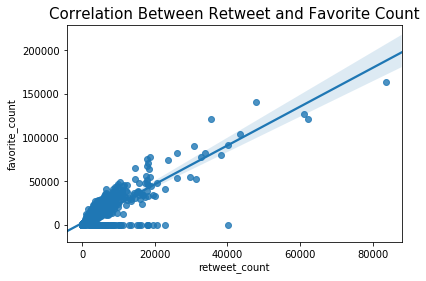

In [83]:
# Make a new dataframe with only the columns we need
df_1 = df_twitter_master[['retweet_count', 'favorite_count']]

# We will use seaborn to make a scatterplot with a regression line
sns.regplot(df_1['retweet_count'], df_1['favorite_count']).set_title(
    "Correlation Between Retweet and Favorite Count", size = 15)

# Save the plot so that we can use it for the separate reports
plt.savefig('Correlation Between Retweet and Favorite Count.jpg')

**Observations:**<br />
I chose this visualization because I noticed that while assessing for 3 insights, the most favorited and most retweeted tweet are the same. It got me thinking what is the correlation betweetn retweet_count and favorite_count variables? By looking at the graph above and doing a visual assessment, we can infer that a greater number of retweets will increase the likelihood that the tweet will also be favorited. There is a steep, positive correlation based on the best fit line of the graph. Every increase in retweet count will get multiple favorite hits. 

### Visualization #2: Algorithms' Success Rate###<br />
We will condense the 3 algorithms with 6 columns into 2 columns by melting it. We will then be able to use this new dataframe to create a boxplot graph. This graph will show how successful each of the alogrithims are compared to one another.

In [84]:
# Start off by gathering the columns from the master dataframe that we only need.
df_2 = df_twitter_master[['p1_conf', 'p1_dog', 'p2_conf', 'p2_dog', 'p3_conf', 'p3_dog']]
df_2.rename(columns={'p1_dog':'p1_bool',
                          'p2_dog':'p2_bool',
                          'p3_dog':'p3_bool'}, 
                 inplace=True)
# Test it out
df_2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,p1_conf,p1_bool,p2_conf,p2_bool,p3_conf,p3_bool
0,0.097049,False,0.085851,False,0.076110,False
1,0.323581,True,0.090647,True,0.068957,True
2,0.716012,True,0.078253,True,0.031379,True
3,0.170278,False,0.168086,True,0.040836,False
4,0.555712,True,0.225770,True,0.175219,True


In [90]:
# We want to melt each of the columns into 2 columns.
p1_df = pd.melt(df_2, value_vars=['p1_conf'],
          var_name='algorithm', value_name='confidence_interval')
p1_df['bool'] = df_2['p1_bool']

# Test it out
p1_df.head()

,algorithm,confidence_interval,bool
0,p1_conf,0.097049,False
1,p1_conf,0.323581,True
2,p1_conf,0.716012,True
3,p1_conf,0.170278,False
4,p1_conf,0.555712,True


In [91]:
# Do the same with the other remaining columns
p2_df = pd.melt(df_2, value_vars=['p2_conf'],
               var_name='algorithm', value_name= 'confidence_interval')
p2_df['bool'] = df_2['p2_bool']

# Test it out
p2_df.head()

,algorithm,confidence_interval,bool
0,p2_conf,0.085851,False
1,p2_conf,0.090647,True
2,p2_conf,0.078253,True
3,p2_conf,0.168086,True
4,p2_conf,0.225770,True


In [92]:
# Do the same with the other remaining columns
p3_df = pd.melt(df_2, value_vars=['p3_conf'],
               var_name='algorithm', value_name= 'confidence_interval')
p3_df['bool'] = df_2['p3_bool']

# Test it out
p3_df.head()

,algorithm,confidence_interval,bool
0,p3_conf,0.076110,False
1,p3_conf,0.068957,True
2,p3_conf,0.031379,True
3,p3_conf,0.040836,False
4,p3_conf,0.175219,True


In [97]:
# Create a new dataframe from the melted dataframes. 
df_2_new = pd.concat([p1_df, p2_df, p3_df], ignore_index= True)

# Test it out
df_2_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 3 columns):
algorithm              6177 non-null object
confidence_interval    6177 non-null float64
bool                   5358 non-null object
dtypes: float64(1), object(2)
memory usage: 144.9+ KB


In [98]:
# Drop the "_conf" in each of the rows because we do not need it anymore
df_2_new['algorithm'].replace('_conf','', regex=True, inplace=True)

# Test it out
df_2_new

,algorithm,confidence_interval,bool
0,p1,0.097049,False
1,p1,0.323581,True
2,p1,0.716012,True
3,p1,0.170278,False
4,p1,0.555712,True
5,p1,0.425595,True
6,p1,0.341703,True
7,p1,0.566142,True
8,p1,0.487574,True
9,p1,0.511319,True


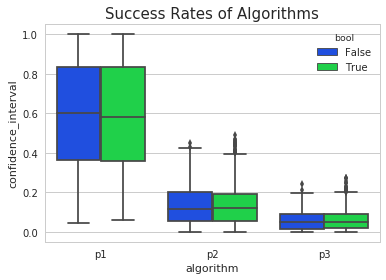

In [104]:
# Set the style of the boxplot to whitegrid
sns.set(style="whitegrid")

# Set boxplot parameters and properties to my liking
sns.boxplot(x="algorithm", y="confidence_interval", hue="bool", data=df_2_new, palette="bright").set_title(
    'Success Rates of Algorithms', size= 15)
plt.figure(figsize=(5, 8))

# Save the figure for the separate reports
plt.savefig('Success Rates of Algorithms.jpg')

**Observations:**<br />
Based on confidence intervals, p1 had highest percentage of confidence but there is a less amount of predictions that came out to be true. With p2, there is less confidence percentage (10-20%) but more predictions that came true. Lastly, p3 had the lowest confidence percentage(5-10%) and had about the same amount of true and false outcomes. The results show that there is approximately an equal amount of True and False outcomes for each of the algorithms, suggesting that each of the algorithms have a success rate of the same.